# A Basic Discussion of the Endogeneity Problem

Many policy discussions routinely invite us to compare policies based on their expected consequences on some variables of interest. For better or for worse, the most intuitive and perhaps compelling way to conduct this evaluation (random controlled trials) is often unavailable. It could be that the experiment is too costly, ethically questionable or that feasible experiments would offer only tengentially related results that need to be extrapolated into unchartered territory to yield a conclusion. Hence, we will generally have to content ourselves of relying on **observational** or **field,** as opposed to **experimental** data.

This notebook uses computer simulations to illustrate two types of problems we can encounter when trying to conduct this kind of statistical analysis in the simplest context possible. In what follows, we assume that we have a dataset $D := \left( y_i, x_{i1}, x_{i2}, z_{i} \right)_{i=1}^N$ where each $i = 1, 2, ..., N$ indicate a different observation, $y$ is the response variable and $x_1, x_2$ and $z$ are variables that affect $y$ in a certain value. We'll also assume that there are other factors which affects $y$, but which we do not observe and we'll call them $\epsilon$. Below, we supply a graph that illustrates the causal relationships among all those variables by using arrows.

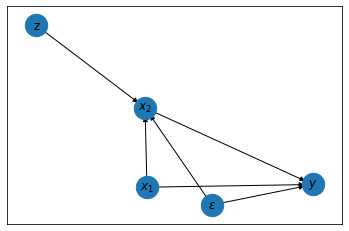

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

SEED = 2098
np.random.seed(SEED)

G = nx.DiGraph()
G.add_edges_from(
    [('$x_1$', '$y$'),        ('$x_2$', '$y$'), ('$\epsilon$', '$y$'), 
     ('$\epsilon$', '$x_2$'), ('z', '$x_2$'), ('$x_1$', '$x_2$')])

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=500)
nx.draw_networkx_labels(G, pos, edge_color='k', arrows=True)
nx.draw_networkx_edges(G,  pos, edge_color='k', arrows=True)
plt.show()

There are three variables that affect $y$ **directly**: $x_1, x_2$ and $\epsilon$. We can also see that $z$ does affect $y$, but only through its impact on $x_2$. We can also see that both $x_2$ and $\epsilon$ also have indirect effects on $y$ through $x_2$.

For the purpose of this notebook, we'll place ourself in the position where we'd like to estimate the causal effet of $x_2$ on $y$. To be more precise, we'd like to know how much we should expect $y$ to change if we vary $x_2$ by some amount $a$ **holding everything else constant.** This is what we call the **average treatment effect (ATE)**. Using $E(A|B)$ to denote the expected value of a random variable $A$ given information $B$, we can define it as follows

\begin{align}
    ATE := E\left( y | x_1, x_2 \right) - E\left( y | x_1, x_2+a \right).
\end{align}

One thing to note is that this quantity may vary with the level of $x_1$, the level of $x_2$, the size of the change $a$ or any combination of those things. Now, we could estimate this difference by finding two groups of people who fit each of  the information sets $(x_1, x_2)$ and $(x_1, x_2+a)$ and just compare their respective average for $y$. This strategy is fairly flexible and doesn't require us to make a lot of assumptions, but you can easily see that we might not have observations for all values of $x_1$ and $x_2$ or how this problem would occur even more often as we increase the number of variables we deem important. One way to work around this problem is to make some assumptions on how these variables interact to be able to pull information from "nearby" cases to fill those gaps.

Suppose, for example, that the data was generated according to
\begin{align}
    y_i    &= \beta_0  + \beta_1 x_{1i} + \beta_2 x_{2i} + \epsilon_i \\
    x_{2i} &= \delta_0 + \delta_1 \epsilon_i + \delta_2 z_i + \delta_3 x_{1i}.
\end{align}

where $\left( \beta_0, \beta_1, \beta_2 \right)$ and $\left( \delta_0, \delta_1, \delta_2, \delta_3 \right)$ are parameters. To see why this is compatible with the graph we saw earlier, note that you can draw arrows from the right hand side to the left hand side when the parameters are not zero. So, when $\delta_2 \neq 0$, we have a line running from $z$ to $x_2$. However, notice that $z$ isn't in the first equation and how it is equivalent to adding $\beta_3 z_i$ with $\beta_3 = 0$: there is no line running directly from $z$ to $y$. Of course, it's not the only set of equations that is consistent with the picture above (e.g., we could add $\beta_4 x_1^2$ to the first or second equation). In a real world example, you'd have to make some choices and justify them. Here, we'll just enforce it during our computer simulations to illustrate two problems.

### Endogeneity

Now we're ready to talk about our two problems. Recalling our definition of the ATE, we would like to estimate the effect of an **exogenous** (*exo* meaning outside) variation of $x_2$ on $y$. That is to say, a variation of $x_2$ that isn't caused by something *inside the system that determines y* such as $\epsilon$ or $x_1$. If this fails, we say that $x_2$ is **endogenous**. In our graph, the arrows running from those variables to $x_2$ are the culprits. In our equations, this appears when $\beta_1 \neq 0$ and $\delta_3 \neq 0$, $\delta_1 \neq 0$ or both. 

Note that if $\beta_2 = 0$ while $\beta_1 \neq 0$ and $\delta_3 \neq 0$, then $x_2$ and $y$ are correlated and, yet, $x_2$ would have absolutely no effect (direct or indirect) on $y$. The culprit here would $x_1$: it would make both of them vary, creating the illusion of causality. This is just one example of why **correlation doesn't imply causation.** The bias here also applies for any value of $\beta_2$: because $x_2$ and $y$ both covary with $x_1$, some of the effect of $x_1$ on $y$ would be misattributed to $x_2$ if we used correlation to estimate a re-scaled version of $\beta_2$.

### A Short Word on Ordinary Least Squares

To estimate $\left( \beta_0, \beta_1, \beta_2 \right)$ we could remind ourselves that $\epsilon$ contains the variation in $y$ that we don't explain and decide, quite intuitively, that we'd like to this to explain as little variable as possible in $y$. Equivalently, we'd like our estimate of $\beta_0  + \beta_1 x_{1i} + \beta_2 x_{2i}$ to explain most of the variation in $y_i$. This strategy naturally leads to an estimator such as **ordinary least squares (OLS)** thus named because it minimizes the sum of squared residuals.

There are very many ways to justify this estimation strategy and to gain intuition on how it behaves, but for our purpose it's enough to say that we don't want to leave too much of the variation of $y$ unexplained. 

We now proceed to illustrate what happens when we use ordinary least squares to estimate parameters in equation 1 in one of three scenarios:

1. $E\left(\epsilon | x_1, x_2 \right) \neq 0$ is the case where we estimate the first equation above without restrictions on parameter values, but the data is generated using $\delta_1 \neq 0$ (some of the unmodeled factors in $\epsilon$ affect both $x_2$ and $y$);

2. $E(\nu|x_2) \neq 0$ is the case where we falsely impose $\beta_1$ during estimation. This means our new error term is $\nu_i := \epsilon_i + \beta_1 x_{i1}$. Since the data is simulated with $\delta_1 = 0$, but $\delta_3 \neq 0$ ($x_1$ affects both $x_2$ and $y$);

3. $E(\epsilon | x_1, x_2 ) = 0$ is the case where we estimate the first equation above without restrictions on parameter values, but the data is generated using $\delta_3 \neq 0$, but $\delta_1 = 0$ so that the only variable that makes $x_2$ can be observed and included in the estimation.

Our idea is to generate many random samples according to both equations above for each of these scenarios. Each time, we'll estimate the first equation and collect the estimate for $\beta_2$. When the method works correctly, it should give us close to the right value on average.

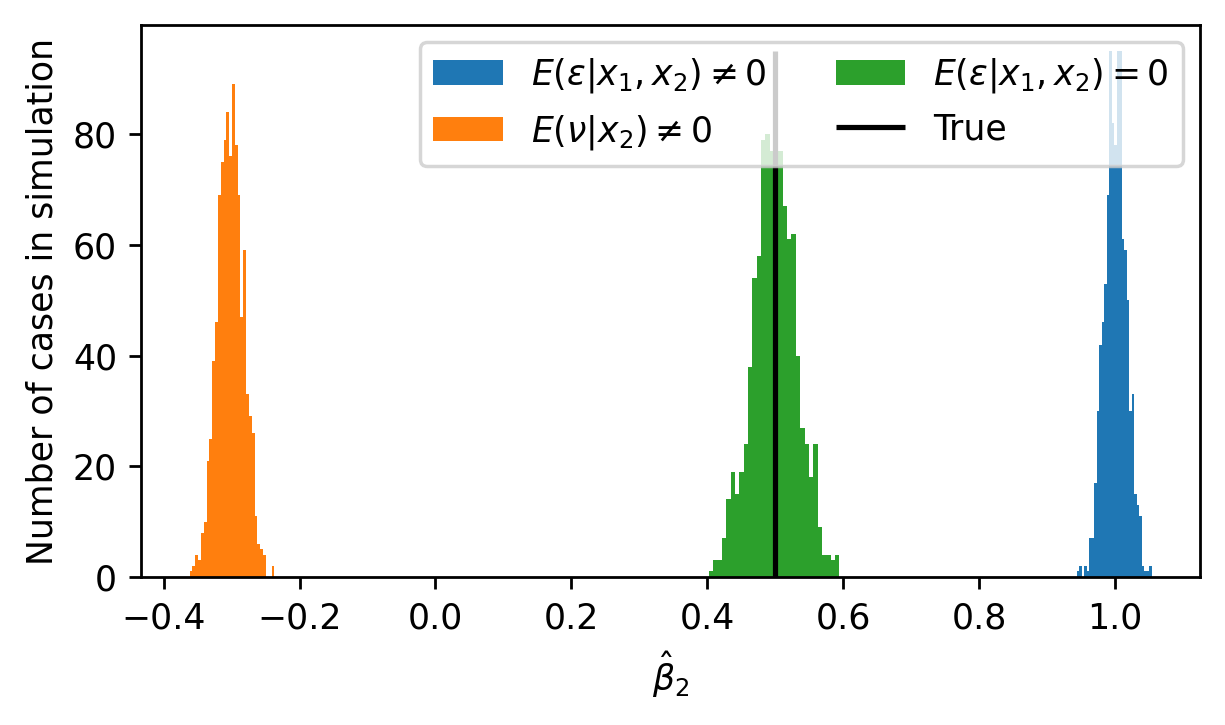

In [5]:
# Parameter values for simulation (picked just to things visually clear)
DELTA0, DELTA1, DELTA2, DELTA3 = 0, 1, 1, -2
BETA0,  BETA1,  BETA2          = 5, 2, 0.5 

NOBS  = 1000 # Number of observations
DRAWS = 1000 # Number of Montre Carlo draws

# This is just the method used to estimate parameters.
def ols(X,y):
    
    XX = X.T @ X
    Xy = X.T @ y
    bhat = np.linalg.inv(XX) @ Xy
    
    return bhat

np.random.seed(SEED)

# To collect estimates
results = np.empty( shape=(DRAWS, 3) )

for m in range(DRAWS):
    
    # Draw random sample
    x1      = np.random.normal(loc=0, scale=1, size=(NOBS, 1)) 
    epsilon = np.random.normal(loc=0, scale=1, size=(NOBS, 1))
    z       = np.random.normal(loc=0, scale=1, size=(NOBS, 1)) 
    
    # Scenario 1: Endogeneity problem through epsilon
    x2 = DELTA0 + DELTA1*epsilon + DELTA2*z
    y  = BETA0 + BETA1*x1 + BETA2*x2 + epsilon
    
    # Build regression matrix
    X = np.hstack( (np.ones(shape=(NOBS,1)), x1, x2) )
    
    # Run OLS
    bhat = ols(X,y)
    
    # Keep results
    results[m,0] = bhat[2]
    
    # Draw random sample
    x1      = np.random.normal(loc=0, scale=1, size=(NOBS, 1)) 
    epsilon = np.random.normal(loc=0, scale=1, size=(NOBS, 1))
    z       = np.random.normal(loc=0, scale=1, size=(NOBS, 1)) 
    
    # Scenario 2: Endogeneity problem through X1 
    x2 = DELTA0 + DELTA2*z + DELTA3*x1
    nu = BETA1*x1 + epsilon
    y  = BETA0 + BETA2*x2 + nu
    
    # Build regression matrix (omit x1)
    X = np.hstack( (np.ones(shape=(NOBS,1)), x2) )
    
    # Run OLS
    bhat = ols(X,y)
    
    # Keep results
    results[m,1] = bhat[1]
    
    # Scenario 3: No Problem (delta1 = 0)
    x2 = DELTA0 + DELTA2*z + DELTA3*x1
    y  = BETA0 + BETA1*x1 + BETA2*x2 + epsilon
    
    # Build regression matrix
    X = np.hstack( (np.ones(shape=(NOBS,1)), x1, x2) )
    
    # Run OLS
    bhat = ols(X,y)
    
    # Keep results
    results[m,2] = bhat[2]
    
# Visualize
fig, ax = plt.subplots(figsize=(5,3), dpi=250)

out = ax.hist( results[:,0], bins=30, label='$E(\\epsilon|x_1, x_2) \\neq 0$' )
ax.hist(       results[:,1], bins=30, label='$E(\\nu|x_2) \\neq 0$' )
ax.hist(       results[:,2], bins=30, label='$E(\\epsilon|x_1, x_2) = 0$' )
ax.vlines(x = BETA2, ymin=min(out[0]), ymax=max(out[0]), label='True')

ax.legend(loc='upper right', ncol=2)
ax.set_xlabel('$\\hat\\beta_2$')
ax.set_ylabel('Number of cases in simulation')

plt.tight_layout()
plt.show()

What we see here is very intuitive. Essentially, as long as noting in the omitted factors that we regroup in our error term covary with variables in included for estimation, we don't have any problem. Otherwise, OLS is going to wrongly attribute to some of the included variables the effect of excluded variables.

This suggest that we can easily solve $E(\nu|x_2) \neq 0$ by simply including the missing variable, assuming we observe it. However, what if we don't have it? That's implicitly what is going on in the first scenario. In that case, we can still find a workaround provided a (or, better many) variable like $z$ exists. The idea is that because $z$ is not correlated with $\epsilon$, its variations could prove useful and because it only affects $y$ through $x_2$, we could exploit its variations to measure the effect of $x_2$ on $y$ (intuitively looking at the graph show at the start, yanking on $z$ to make $x_2$ move is a kind of exogenous variation). That's how **instrumental variable** estimators work. Below, we implement a simple version example of it.

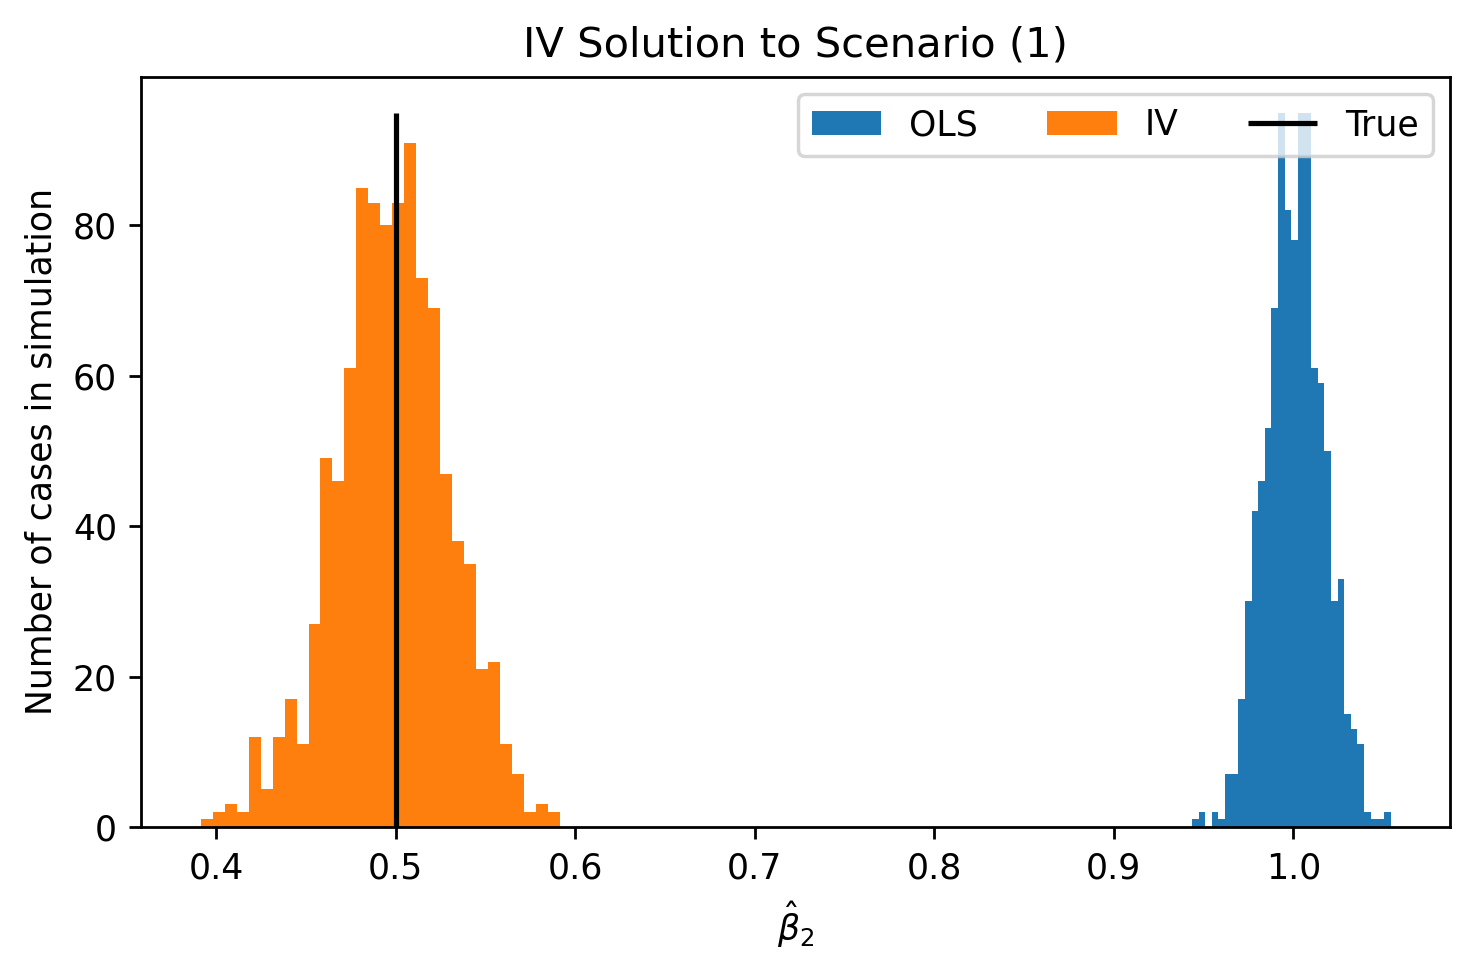

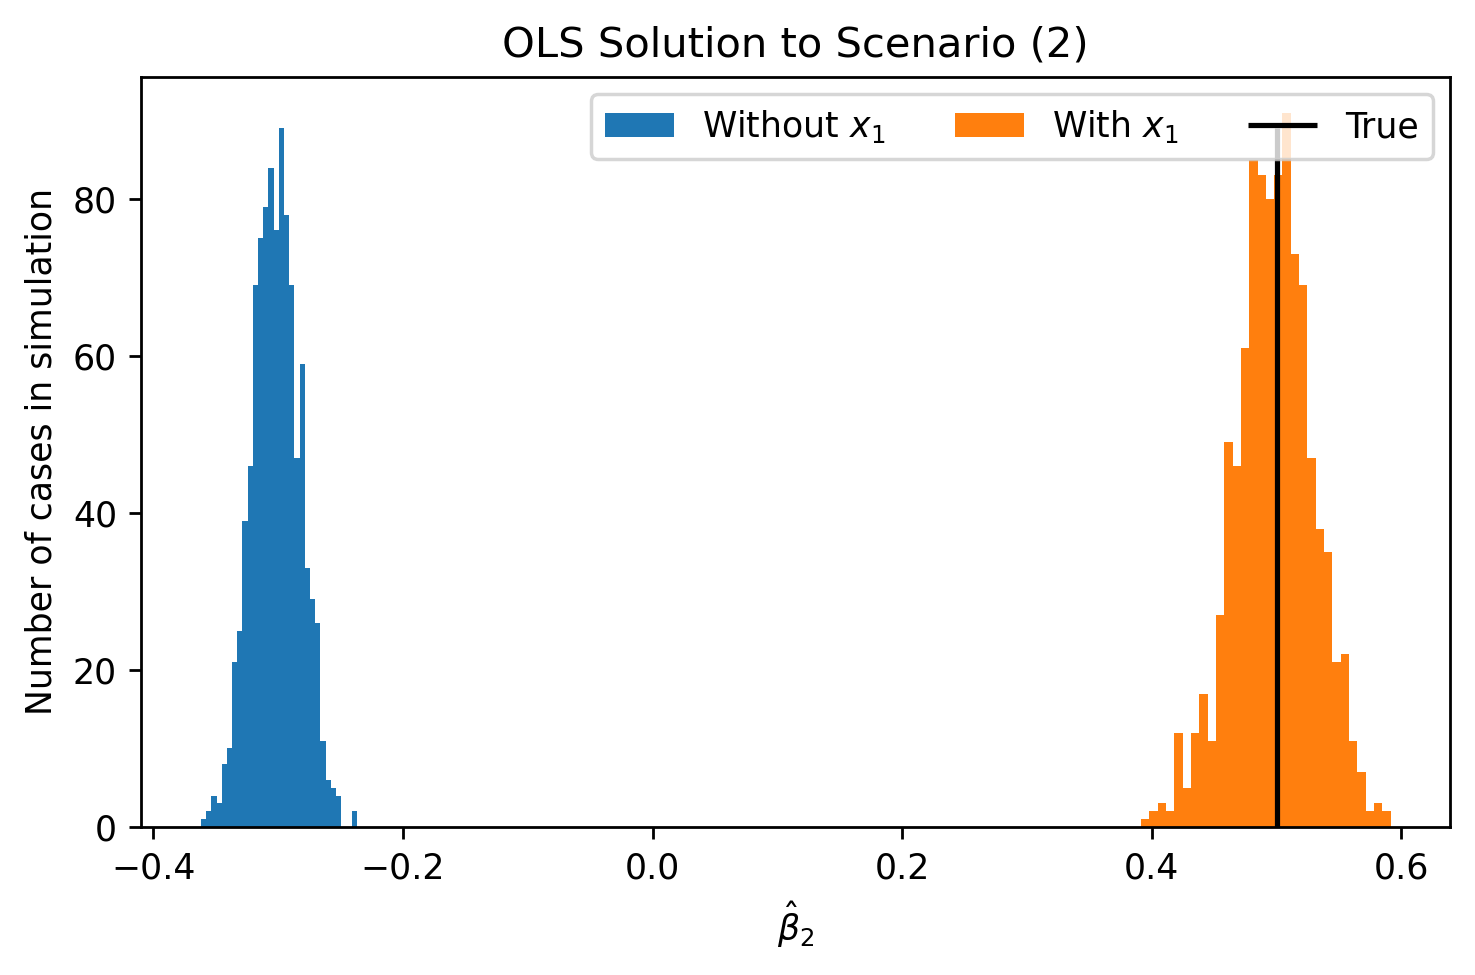

In [10]:

np.random.seed(SEED)

# To collect results
results2 = np.empty( shape=(DRAWS,2) )

for m in range(DRAWS):
    
    # Draw random sample
    x1      = np.random.normal(loc=0, scale=1, size=(NOBS, 1)) 
    epsilon = np.random.normal(loc=0, scale=1, size=(NOBS, 1))
    z       = np.random.normal(loc=0, scale=1, size=(NOBS, 1)) 
    
    # Problem 1: Endogeneity through epsilon
    x2 = DELTA0 + DELTA1*epsilon + DELTA2*z
    y  = BETA0  + BETA1*x1 + BETA2*x2 + epsilon
    
    # Build regression matrices
    # Variable in main equation
    X = np.hstack( (np.ones(shape=(NOBS,1)), x1, x2) )
    # Same, except replace endogenous variables by excluded variables
    Z = np.hstack( (np.ones(shape=(NOBS,1)), x1, z ) )
    
    # Apply IV
    biv = iv(X,Z,y)
    
    # Keep results
    results2[m,0] = biv[2]
    
    # Problem 2: Endogeneity through X1
    x2 = DELTA0 + DELTA2*z + DELTA3*x1
    nu = BETA1*x1 + epsilon
    y  = BETA0 + BETA2*x2 + nu
    
    # Build regression matrices
    X = np.hstack( (np.ones(shape=(NOBS,1)), x1, x2) )
    
    # Aplly ols
    bhat = ols(X,y)
    
    # Keep results
    results2[m,1] = biv[2]
    
# Visualize IV solution
fig, ax = plt.subplots(figsize=(6,4), dpi=250)

out = ax.hist( results[:,0],  bins=30, label='OLS' )
ax.hist(       results2[:,0], bins=30, label='IV' )
ax.vlines(x = BETA2, ymin=min(out[0]), ymax=max(out[0]), label='True')

ax.legend(loc='upper right', ncol=3)
ax.set_xlabel('$\\hat\\beta_2$')
ax.set_ylabel('Number of cases in simulation')
ax.set_title('IV Solution to Scenario (1)')

plt.tight_layout()
plt.show()

# Visualize OLS solution
fig, ax = plt.subplots(figsize=(6,4), dpi=250)

out = ax.hist( results[:,1],  bins=30, label='Without $x_1$' )
ax.hist(       results2[:,1], bins=30, label='With $x_1$' )
ax.vlines(x = BETA2, ymin=min(out[0]), ymax=max(out[0]), label='True')

ax.legend(loc='upper right', ncol=3)
ax.set_xlabel('$\\hat\\beta_2$')
ax.set_ylabel('Number of cases in simulation')
ax.set_title('OLS Solution to Scenario (2)')

plt.tight_layout()
plt.show()